# Spectra of Adversarial Examples

In [1]:
import math
import sys
import os
import numpy as np
import matplotlib.pyplot as ppt
import caffe
import adex
import adex.data
import adex.googlenet
%matplotlib inline
caffe.set_mode_cpu()

CAFFE_ROOT = '/home/chrisbot/Projects/caffe'
DATA_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train'
AE_ROOT = '/media/sf_Masterarbeit/data/ILSVRC2012_img_train_AE_50'

BATCH_SIZE = 1
net = adex.googlenet.load_model(CAFFE_ROOT, BATCH_SIZE)
transformer = adex.googlenet.build_transformer(net)

In [2]:
original_spectrum = None
original_spectrum_count = 0
adversarial_spectrum = None
adversarial_spectrum_count = 0

original_sampe_count = 0 # FIXME remove this
for start_pic_name in os.listdir(AE_ROOT):
    if not os.path.isdir(AE_ROOT + '/' + start_pic_name):
        continue
    
    for out_file_name in os.listdir(AE_ROOT + '/' + start_pic_name):
        out_file_path = AE_ROOT + '/' + start_pic_name + '/' + out_file_name
        
        ae_image = np.load(out_file_path) # Load from disk
        ae_image = adex.data.grayvalue_image(ae_image) # Convert from RGB to Grayvalue
        ae_image = ae_image[...,:-1,:-1] # Make dimensions odd, required for symmetry
        ae_image = ae_image / math.sqrt(np.sum(ae_image**2)) # Normalize
        ae_image_spectrum = adex.data.get_spectrum(ae_image) # Compute Spectrum
        
        if adversarial_spectrum is None:
            adversarial_spectrum = np.zeros_like(ae_image_spectrum)
        adversarial_spectrum += ae_image_spectrum
        adversarial_spectrum_count += 1
    
    start_class_name = start_pic_name.split('_')[0]
    for in_file_name in os.listdir(DATA_ROOT + '/' + start_class_name):
        in_file_path = DATA_ROOT + '/' + start_class_name + '/' + in_file_name
        
        image = adex.googlenet.load_image(transformer, in_file_path)
        image = adex.data.grayvalue_image(image)
        image = image[...,:-1,:-1] # Make dimensions odd, required for symmetry
        image = image / math.sqrt(np.sum(image**2))
        image_spectrum = adex.data.get_spectrum(image)

        if original_spectrum is None:
            original_spectrum = np.zeros_like(image_spectrum)
        original_spectrum += image_spectrum
        original_spectrum_count += 1
        
        original_sampe_count += 1
        if original_sampe_count > 10:
            original_sampe_count = 0
            break
    
    sys.stdout.write('.')
    sys.stdout.flush()

..................................................

In [3]:
# Normalize spectra and get the log difference
original_spectrum /= original_spectrum_count
adversarial_spectrum /= adversarial_spectrum_count

difference_of_log_spectra = np.log(original_spectrum) - np.log(adversarial_spectrum)

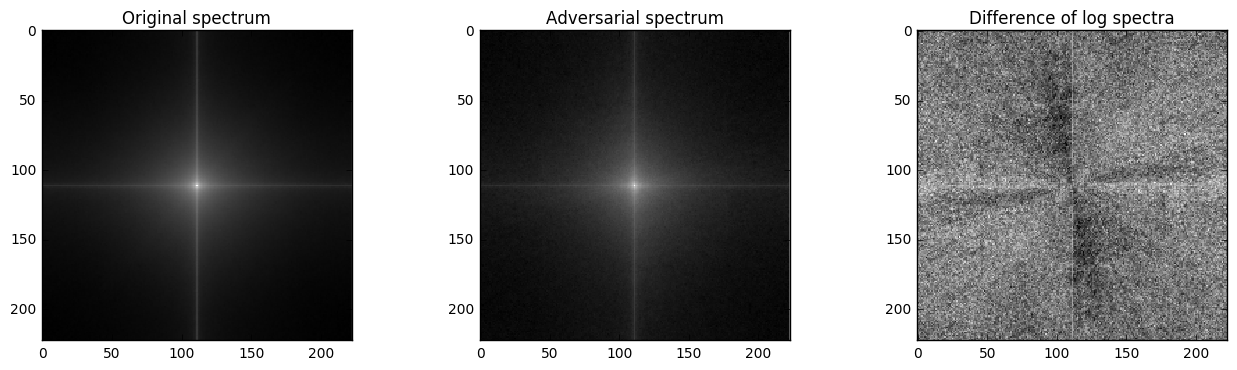

In [4]:
ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ppt.imshow(np.log(original_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Original spectrum')

ax = ppt.subplot(1, 3, 2)
ppt.imshow(np.log(adversarial_spectrum[0, 0]), cmap='gray', interpolation='none')
ppt.title('Adversarial spectrum')

ax = ppt.subplot(1, 3, 3)
ppt.imshow(difference_of_log_spectra[0, 0], cmap='gray', interpolation='none')
ppt.title('Difference of log spectra')

In [5]:
def activity_distribution(spectrum, range_bins, angle_bins):
    spectrum = spectrum.reshape(spectrum.shape[-2:])
    if spectrum.shape[0] % 2 == 0: # If side length is even
        center = np.asarray(spectrum.shape) / 2 - np.asarray([1,1])
        spectrum = spectrum[1:,1:] # cut off asymmetric parts, shape is now uneven
    else: # Side length is odd
        center = np.asarray(spectrum.shape) / 2

    # Record the summed values at every distance and angle to the origin, and the number of summed values
    distance_distribution = np.zeros(shape=(2, range_bins))
    angle_distribution = np.zeros(shape=(2, angle_bins))
    
    # Maxima, the bins scale linearly between 0 and these values
    max_distance = math.ceil(np.linalg.norm(center))
    max_angle = 2 * math.pi
    
    for index, value in np.ndenumerate(spectrum):
        # Compute distance to origin and the corresponding bin index
        distance = np.linalg.norm(np.asarray(index) - center)
        distance_index = (distance / max_distance) * range_bins
        distance_index = int(math.floor(distance_index))
        distance_distribution[:, distance_index] += (value, 1) # Record data in appropriate bin
        
        # Compute angle and the corresponding bin index
        angle = math.atan2(center[0] - index[0], index[1] - center[1])
        if angle < 0: # atan2 gives values from -pi to pi. Shift them to 0 to 2pi
            angle += 2 * math.pi
        angle_index = (angle / max_angle) * angle_bins # from 0 to angle_bins
        angle_index = int(math.floor(angle_index))
        
        if not (np.asarray(index) == center).all(): #ignore origin since it has no well-defined angle
            angle_distribution[:, angle_index] += (value, 1) # Record data in appropriate bin
    
    # Normalize with the number of summed values. Use 0 if there was no point at that distance.
    distance_distribution = np.where(distance_distribution[1] == 0, 0, distance_distribution[0] / distance_distribution[1])
    angle_distribution = angle_distribution[0] / (angle_distribution[1])
    
    return distance_distribution, angle_distribution

# Plot the distribution of frequencies over distance from the origin on a log scale
distance_bins = int(round(np.linalg.norm(original_spectrum.shape) / 2))
angle_bins = 8
print('Using {0} distance bins and {1} angle bins'.format(distance_bins, angle_bins))
original_distance_distribution, original_angle_distribution = activity_distribution(original_spectrum, distance_bins, angle_bins)
adversarial_distance_distribution, adversarial_angle_distribution = activity_distribution(adversarial_spectrum, distance_bins, angle_bins)
diff_distance_distribution, diff_angle_distribution = activity_distribution(difference_of_log_spectra, distance_bins, angle_bins)

Using 158 distance bins and 8 angle bins


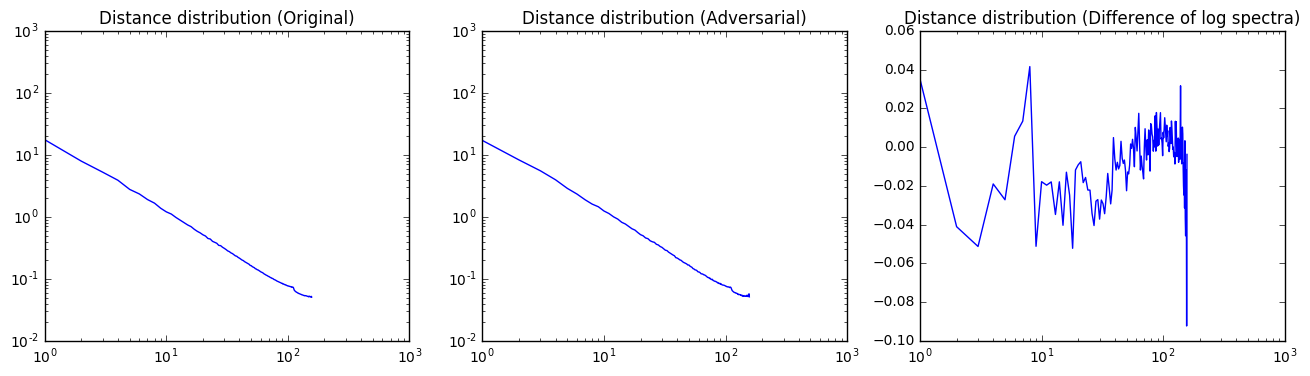

In [6]:
ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(original_distance_distribution)
ppt.title('Distance distribution (Original)')

ax = ppt.subplot(1, 3, 2)
ax.set_xscale('log')
ax.set_yscale('log')
ppt.plot(adversarial_distance_distribution)
ppt.title('Distance distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
ax.set_xscale('log')
#ax.set_yscale('log')
ppt.plot(diff_distance_distribution)
ppt.title('Distance distribution (Difference of log spectra)')

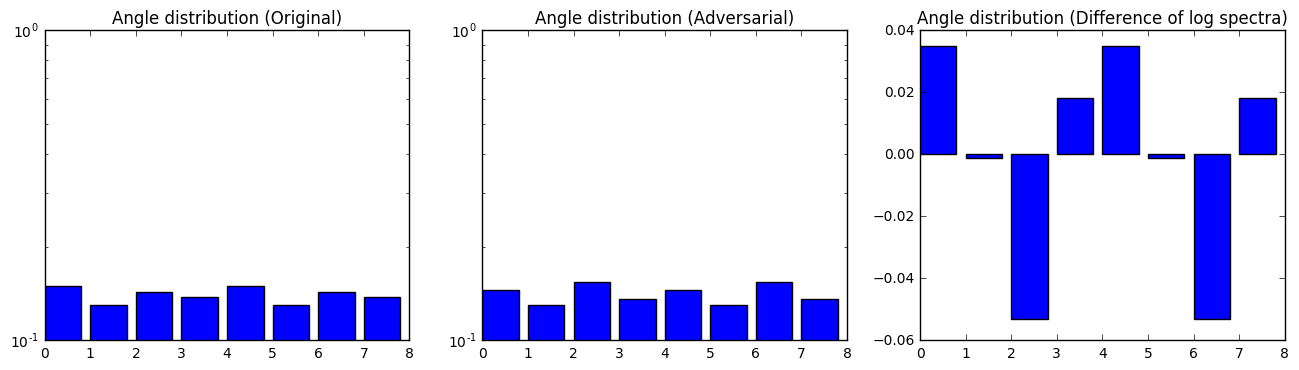

In [7]:
ppt.figure(figsize=(16, 4))

ax = ppt.subplot(1, 3, 1)
#ax.set_xscale('log')
ax.set_yscale('log')
#ppt.plot(original_angle_distribution)
ppt.bar(np.arange(angle_bins), original_angle_distribution)
ppt.title('Angle distribution (Original)')

ax = ppt.subplot(1, 3, 2)
#ax.set_xscale('log')
ax.set_yscale('log')
#ppt.plot(adversarial_angle_distribution)
ppt.bar(np.arange(angle_bins), adversarial_angle_distribution)
ppt.title('Angle distribution (Adversarial)')

ax = ppt.subplot(1, 3, 3)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ppt.plot(diff_angle_distribution)
ppt.bar(np.arange(angle_bins), diff_angle_distribution)
ppt.title('Angle distribution (Difference of log spectra)')